# Naive word2vec

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch (numpy too, if you love to calculate gradients on your own and want some extra points, but don't forget to numerically check your gradients) and code from your previous task. Again: you don't have to implement negative sampling (you may reduce your vocabulary size for faster computation).

**Results of this task**:
 * trained word vectors (mention somewhere, how long it took to train) -- train
 * plotted loss (so we can see that it has converged) -- Ok
 * function to map token to corresponding word vector -- Ok
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task) -- OK
 * qualitative evaluations of word vectors: nearest neighbors, word analogies -- OK
 
 TODO: 
 save to google drive,
 not turning off of googlecolab,
 try the whole text with huge embed_size of 100-300 //done in the next tasks

**Extra:**
 * quantitative evaluation:
   * for intrinsic evaluation you can find datasets [here](https://aclweb.org/aclwiki/Analogy_(State_of_the_art))
   * for extrincis evaluation you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation. If you chose to do this, please use the same datasets across tasks 3, 4, 5 and 6.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec]()

If you struggle with something, ask your neighbor. If it is not obvious for you, probably someone else is looking for the answer too. And in contrast, if you see that you can help someone - do it! Good luck!

In [2]:
"""my implemenatation of word2vec embedding model: https://arxiv.org/pdf/1411.2738.pdf"""
"""please open it using Google Colab"""
import tensorflow as tf
from tensorflow.train import AdamOptimizer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
import numpy as np
import random
from collections import Counter

unknown_token = "UNK"

class SkipGramBatcher:
    def __init__(self, window_size=5, least_freq=3):
        self.least_freq = least_freq
        self.text = None
        self.vocab = None
        self.vocab_size = None
        self.word2index = None
        self.index2word = None
        self.window_size = window_size
        self.current_index = 0
        self.current_diff = -window_size
        self.total_size = 0
    
    def preprocess(self, text):
        """replace words with frequency < least_freq with unknown_token
        and save the text
        """
        counter = Counter(text)
        def get_token(word):
            if counter[word] < self.least_freq:
                return unknown_token
            else:
                return word.lower()
        self.text = [get_token(word) for word in text]
    
    def fit_text(self, text):
        """init text, vocab, word2ind, ind2word
        """
        self.preprocess(text)
        self.vocab = np.unique(self.text)
        self.vocab_size = self.vocab.shape[0]
        self.word2index = dict(zip(self.vocab, range(self.vocab.shape[0])))
        self.index2word = dict(zip(range(self.vocab.shape[0]), self.vocab))
        self.total_size = (len(self.text) - 3 * self.window_size) * self.window_size * 2
        
    def most_frequent(self, num=25):
        counter = Counter(self.text)
        return counter.most_common(num)
        
    def least_frequent(self, num=25):
        counter = Counter(self.text)
        return counter.most_common()[:-num - 1:-1]
        
    def indices_to_words(self, x_batch):
        return np.array([self.index2word[index] for index in x_batch])
    
    def words_to_indices(self, words):
        return np.array([self.word2index[word] for word in words])
    
    def get_next_index_and_diff(self, current_index, current_diff):
        if (current_diff == self.window_size):
            current_diff = -self.window_size
            current_index += 1
            current_index %= len(self.text)
        else:
            if current_diff == -1:
                current_diff = 1
            else:
                current_diff += 1
        return current_index, current_diff

    
    def get_batch(self, batch_size=100):
        x_batch = []
        labels_batch = []
        while len(x_batch) < batch_size:
            label_index_in_text = self.current_index + self.current_diff 
            if (label_index_in_text < 0 or label_index_in_text >= len(self.text)):
                index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
                self.current_index = index
                self.current_diff = diff
                continue
                
            word = self.text[self.current_index]
            word_index = self.word2index[word]
            label = self.text[self.current_index + self.current_diff]
            label_index = self.word2index[label]
            
            x_batch.append(word_index)
            labels_batch.append(label_index)
            
            index, diff = self.get_next_index_and_diff(self.current_index, self.current_diff)
            self.current_index = index
            self.current_diff = diff
            
        assert len(x_batch) == batch_size
        assert len(labels_batch) == batch_size
        
        x_batch = np.array(x_batch)
        labels_batch = np.array(labels_batch)
        
        permut = np.random.permutation(range(batch_size))
        x_batch = x_batch[permut]
        labels_batch = labels_batch[permut]
        return x_batch, labels_batch
    
    def batch_generator(self, batch_size=100):
        while True:
            x_batch, labels_batch = self.get_batch(batch_size)
            yield x_batch, labels_batch

In [5]:
!mkdir logs_new
!ls
!wget http://mattmahoney.net/dc/text8.zip

logs_new  sample_data
--2019-03-05 18:36:41--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   326KB/s    in 94s     

2019-03-05 18:38:16 (326 KB/s) - ‘text8.zip’ saved [31344016/31344016]



In [6]:
!ls
!unzip text8.zip

logs_new  sample_data  text8.zip
Archive:  text8.zip
  inflating: text8                   


In [27]:
!ls
!ls -l logs_new

Graph  logs_new  sample_data  text8  text8.zip


In [8]:
filename = 'text8' #file with the raw text
text = []
with open('text8', mode='r') as file:
    line = file.readline()
    while line:
        text += line.lower().split(' ')
        line = file.readline()
        if len(text) > 100000:
            print(len(text))
            break

17005208


In [0]:
batcher = SkipGramBatcher(window_size=5, least_freq=3)
batcher.fit_text(text[:1000000])

In [10]:
USE_GPU = True
if USE_GPU:
    device = '/device:GPU:0'
else:
    device = '/cpu:0'
    
print('Using device: ', device)

Using device:  /device:GPU:0


In [11]:
from IPython.core.display import HTML

color="255,127,80"  # coral

def print_training_progress(c, text):
    source = "<small><small><h1 style='color: rgb({0})'>{1}</h1></small></small>".format(c, text)
    return HTML(source)

print_training_progress(color, 'test')

In [0]:
def kaiming_normal(shape):
    return tf.random_normal(shape) * np.sqrt(2.0 / shape[0])

In [0]:
save_every = 200
loss_every = 200
summary_every = 50
log_every = 50
USE_TENSORBOARDCOLAB = True

In [0]:
class Word2Vec:
    def __init__(self, vocab_size, embeddings_size):
        tf.reset_default_graph()
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
        self.vocab_size = vocab_size
        self.embeddings_size = embeddings_size
        
    def close(self):
        tf.reset_default_graph()
        self.sess.close()
        
    def init_weights(self):
        self.w1 = tf.Variable(kaiming_normal((self.vocab_size, self.embeddings_size)), name='w1')
        self.w2 = tf.Variable(kaiming_normal((self.embeddings_size, self.vocab_size)), name='w2')
        
    def model_fn(self, x):
        x = tf.matmul(x, self.w1)
        x = tf.matmul(x, self.w2)
        return x
    
    def get_loss(self, scores, y):
        losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=scores)
        loss = tf.reduce_mean(losses)
        return loss
    
    def train(self, batcher, batch_size=10, epochs=3, learning_rate=0.01):        
        with tf.device(device):
            self.init_weights()
            
            x = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            y = tf.placeholder(dtype=tf.int32, shape=(batch_size))
            
            x_one_hot = tf.one_hot(x, self.vocab_size)
            
            scores = self.model_fn(x_one_hot)
            loss = self.get_loss(scores, y)
            tf.summary.scalar('cross_entropy', loss)
            
            train_op = AdamOptimizer(learning_rate).minimize(loss)
            
            saver = tf.train.Saver({"w1" : self.w1, "w2" : self.w2})
            merged = tf.summary.merge_all()
            
            if USE_TENSORBOARDCOLAB:
                tbc = TensorBoardColab()
                train_writer = tbc.get_writer()
                print()
                print('initialized writer for tensorboard logging...')
                print()
            else:
                train_writer = tf.summary.FileWriter('./tensorboard/train')
            
            #training
            self.sess.run(tf.global_variables_initializer())
            
            min_loss = 1e9
            losses = []
            print('Starting training...')
            try:
                for epoch in range(epochs):
                    iter_count = int(batcher.total_size / batch_size)
                    for step in range(iter_count):
                        x_batch, labels_batch = batcher.get_batch(batch_size)
                        feed_dict = {x : x_batch, y : labels_batch}
                        
                        if step % summary_every == 0:
                            print('writing summary to tensorboard...')
                            print()
                            summary = self.sess.run(merged, feed_dict=feed_dict)
                            train_writer.add_summary(summary, iter_count * epoch + step)
                        
                        np_loss, _ = self.sess.run([loss, train_op], feed_dict=feed_dict)
                        
                        if step % log_every == 0:
                            print('running epoch: {}, step: {}, loss = {}...'.format(epoch, step, np_loss))
                            print()

                        if min_loss > np_loss:
                            saver.save(self.sess, "./logs/model_min_loss.ckpt")
                            print("minimal loss updated from {} to {} | at step {}...".format(min_loss, np_loss, step))
                            min_loss = np_loss
                            print("Model weights and loss saved in ./logs/model_min_loss.ckpt | at step {}...".format(step))
                            print()
                        if step % save_every == 0:
                            saver.save(self.sess, "./logs/model_default_save.ckpt")
                            print("Model with loss = {} saved to ./logs/model_default_save.ckpt | at step {}...".format(np_loss, step))
                            print()
                        if step % loss_every == 0:
                            if len(losses) > 10000000:
                                print('Already a lot losses...')
                            else:
                                losses.append(np_loss)
                                print("Losses saved to ./logs/losses_history... | at step {}".format(step))
                                print()
                                np.save('./logs/losses_history', np.array(losses))
            except KeyboardInterrupt:
                print('KeyboardInterrupt')
    
    def get_vectors_from_words(self, batcher, words):
        if not isinstance(words, list):
            words = [words]
        with tf.device(device):
            indexes = [batcher.word2index[word] for word in words]
            x = tf.placeholder(dtype=tf.int32, shape=(len(indexes)))
            x_one_hot = tf.one_hot(x, self.vocab_size)
            x_one_hot = tf.cast(x_one_hot, tf.float32)
            predicted = tf.matmul(x_one_hot, self.w1)
           
            embeddings = self.sess.run(predicted, feed_dict={x : indexes})
            return embeddings
    
    def get_vectors_from_indexes(self, batcher, indexes):
        words = [batcher.index2word[index] for index in indexes]
        return self.get_vectors_from_words(batcher, words)

In [60]:
EMBEDDINGS_SIZE = 40
BATCH_SIZE = 10000
EPOCHS = 100
LEARNING_RATE = 0.01
model = Word2Vec(batcher.vocab_size, EMBEDDINGS_SIZE)
model.train(batcher, BATCH_SIZE, EPOCHS, LEARNING_RATE)

Wait for 8 seconds...
TensorBoard link:
http://07c82aac.ngrok.io

initialized writer for tensorboard logging...

Starting training...
writing summary to tensorboard...

running epoch: 0, step: 0, loss = 9.926493644714355...

minimal loss updated from 1000000000.0 to 9.926493644714355 | at step 0...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 0...

Model with loss = 9.926493644714355 saved to ./logs/model_default_save.ckpt | at step 0...

Losses saved to ./logs/losses_history... | at step 0

minimal loss updated from 9.926493644714355 to 9.92212200164795 | at step 1...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 1...

minimal loss updated from 9.92212200164795 to 9.919221878051758 | at step 2...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 2...

minimal loss updated from 9.919221878051758 to 9.907096862792969 | at step 3...
Model weights and loss saved in ./logs/model_min_loss.ckpt | at step 3...

minimal loss upd

In [0]:
def plot_words(indixes, embeddings):
    """embeddings of shape num_values * embed_dimenssion"""
    tsne = TSNE(n_components=2, init="pca", n_iter=1000)
    print('TSNE calculated...')
    transformed = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(15, 15))
    words = [batcher.index2word[index] for index in indixes]
    for i, word in enumerate(words):
        x, y = transformed[i, :]
        plt.scatter(x, y)
        plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points", ha="right", va="bottom")
    plt.show()

In [31]:
"""function to map token to corresponding word vector"""
embeddings = model.get_vectors_from_words(batcher, ['anarchism', 'UNK'])

['anarchism', 'UNK']
[1005, 0]


In [32]:
print(embeddings.shape)

(2, 40)


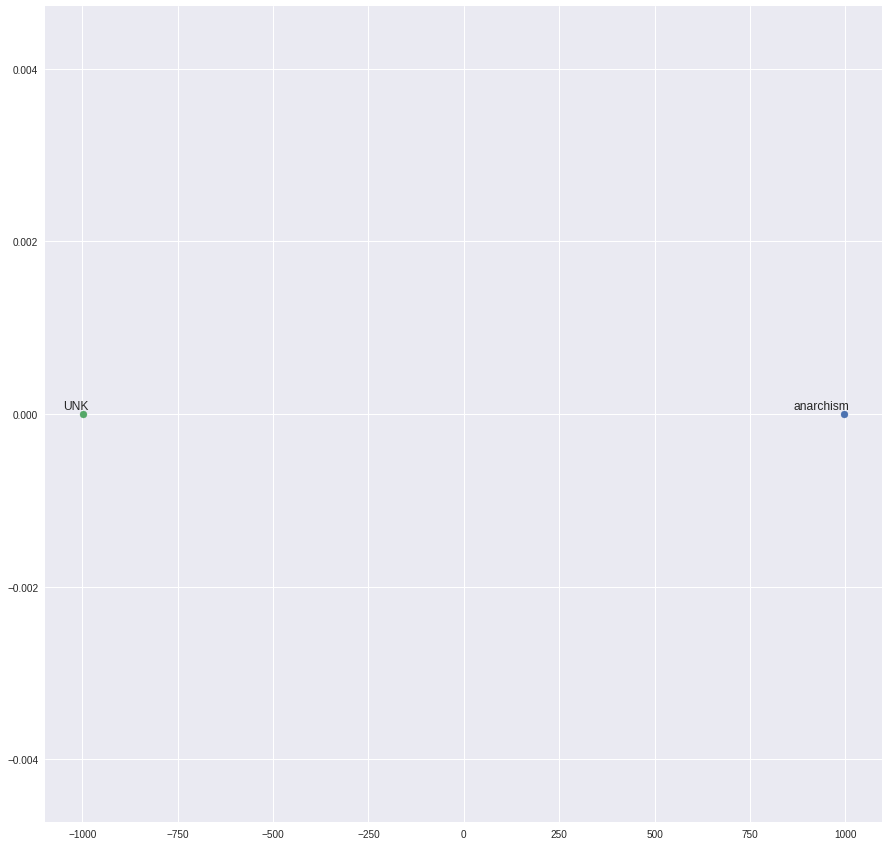

In [33]:
plot_words([1005, 0], embeddings)

In [78]:
indices = np.arange(batcher.vocab_size)
np.random.shuffle(indices)
indices = indices[:1000]
embed_from_indices = model.get_vectors_from_indexes(batcher, indices)
print(embed_from_indices.shape)

(1000, 40)


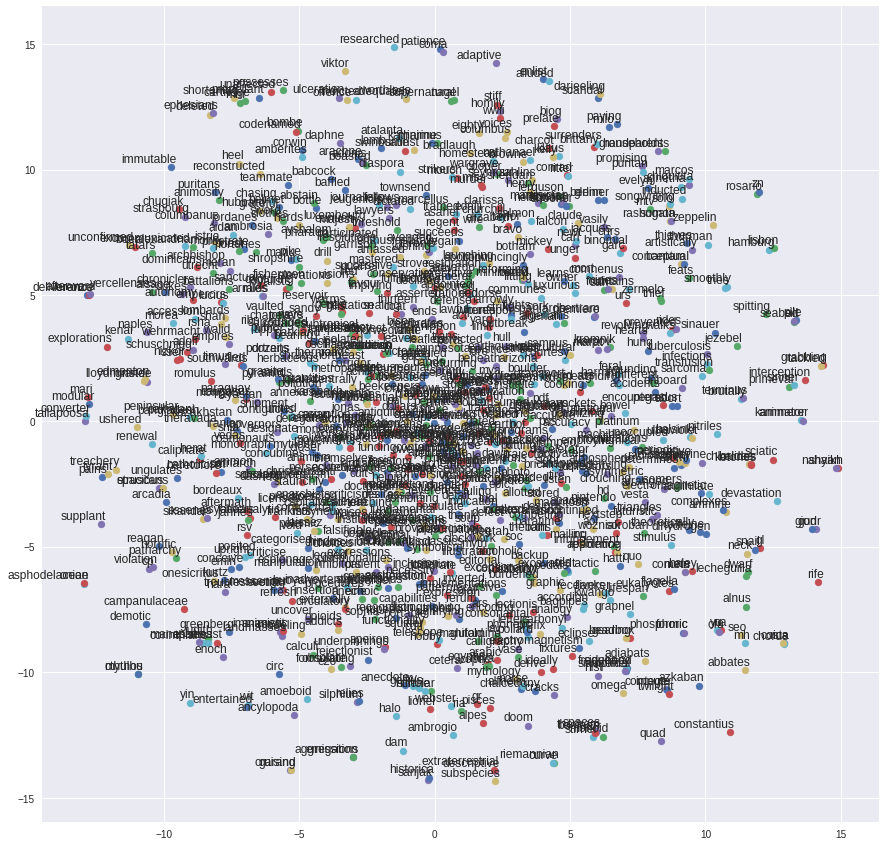

In [79]:
plot_words(indices, embed_from_indices)

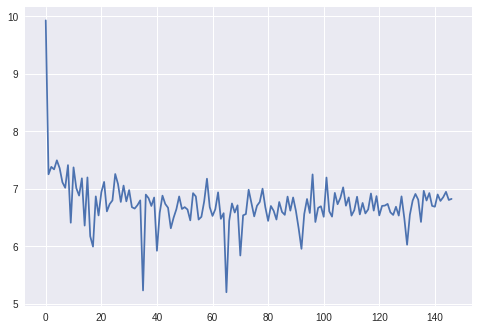

In [64]:
"""plot loss without tensorboard"""
losses = np.load('./logs/losses_history.npy')
plt.plot(losses)
plt.show()

In [106]:
!ls -l

total 137300
drwxr-xr-x 2 root root      4096 Mar  5 19:25 Graph
drwxr-xr-x 2 root root      4096 Mar  5 21:01 logs
drwxr-xr-x 2 root root      4096 Mar  5 18:55 logs_new
drwxr-xr-x 1 root root      4096 Feb 26 17:33 sample_data
-rw-r--r-- 1 root root 100000000 Jun  9  2006 text8
-rw-r--r-- 1 root root  31344016 Jul 23  2009 text8.zip
-rw-r--r-- 1 root root   9225292 Mar  5 21:12 word2vec.vec


In [81]:
print(batcher.vocab_size)
embeddings = model.get_vectors_from_indexes(batcher, range(batcher.vocab_size))

20462


In [0]:
"""nearest neighbors, word analogies using gensim"""
def create_file_for_gensim(embeddings, vocab_size, vec_size, filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size) + ' ' + str(vec_size) + '\n')
        for i in range(vocab_size):
            to_write = ' '.join([batcher.index2word[i]] + [str(num) for num in embeddings[i]])
            f.write(to_write + '\n')

create_file_for_gensim(embeddings, embeddings.shape[0], EMBEDDINGS_SIZE, 'word2vec.vec')

In [0]:
from gensim.models import KeyedVectors
w2v = KeyedVectors.load_word2vec_format('word2vec.vec', binary=False)

In [0]:
def print_similar(similar_to):
  for similar in w2v.similar_by_word(similar_to)[:20]:
      print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

In [92]:
print_similar('good')

word: thing, similarity: 0.75
word: what, similarity: 0.74
word: reason, similarity: 0.70
word: example, similarity: 0.70
word: just, similarity: 0.69
word: soup, similarity: 0.69
word: better, similarity: 0.69
word: perfect, similarity: 0.69
word: man, similarity: 0.69
word: kind, similarity: 0.68


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [93]:
print_similar('dog')

word: eat, similarity: 0.80
word: grass, similarity: 0.70
word: praying, similarity: 0.64
word: appreciation, similarity: 0.62
word: spot, similarity: 0.62
word: sweet, similarity: 0.61
word: vulture, similarity: 0.61
word: seasons, similarity: 0.61
word: friendly, similarity: 0.60
word: satire, similarity: 0.60


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [99]:
print_similar('king')

word: kings, similarity: 0.77
word: son, similarity: 0.74
word: alexander, similarity: 0.73
word: macedon, similarity: 0.72
word: iii, similarity: 0.71
word: philip, similarity: 0.71
word: daughter, similarity: 0.71
word: emperor, similarity: 0.70
word: exiled, similarity: 0.68
word: khan, similarity: 0.68


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [100]:
print_similar('queen')

word: prince, similarity: 0.70
word: victoria, similarity: 0.70
word: elizabeth, similarity: 0.69
word: canada, similarity: 0.69
word: king, similarity: 0.67
word: princess, similarity: 0.66
word: lord, similarity: 0.65
word: tutuila, similarity: 0.65
word: ireland, similarity: 0.65
word: flag, similarity: 0.64


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [101]:
print_similar('mother')

word: wife, similarity: 0.86
word: father, similarity: 0.85
word: death, similarity: 0.81
word: daughter, similarity: 0.81
word: son, similarity: 0.79
word: whom, similarity: 0.76
word: she, similarity: 0.74
word: friend, similarity: 0.73
word: her, similarity: 0.73
word: died, similarity: 0.72


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [102]:
print_similar('vegetable')

word: soil, similarity: 0.73
word: vegetables, similarity: 0.71
word: corn, similarity: 0.71
word: outputs, similarity: 0.68
word: products, similarity: 0.66
word: leaf, similarity: 0.64
word: fruits, similarity: 0.64
word: wood, similarity: 0.64
word: tobacco, similarity: 0.63
word: trees, similarity: 0.63


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [105]:
print_similar('elephant')

word: eel, similarity: 0.74
word: emu, similarity: 0.70
word: lion, similarity: 0.69
word: hippopotamus, similarity: 0.67
word: buffalo, similarity: 0.66
word: elk, similarity: 0.66
word: beetle, similarity: 0.65
word: bear, similarity: 0.63
word: cheetah, similarity: 0.63
word: slug, similarity: 0.63


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [111]:
similar_words = w2v.most_similar(positive=['king', 'woman'], negative=['man'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: daughter, similarity: 0.68
word: consul, similarity: 0.65
word: lucius, similarity: 0.63
word: iv, similarity: 0.62
word: emperor, similarity: 0.62
word: murdered, similarity: 0.61
word: iii, similarity: 0.61
word: spartan, similarity: 0.61
word: son, similarity: 0.61
word: sons, similarity: 0.60


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [112]:
similar_words = w2v.most_similar(positive=['girl', 'father'], negative=['mother'])
for similar in similar_words:
    print("word: {0}, similarity: {1:.2f}".format(similar[0], similar[1]))

word: cub, similarity: 0.65
word: variant, similarity: 0.63
word: version, similarity: 0.63
word: old, similarity: 0.63
word: sportsman, similarity: 0.61
word: abdul, similarity: 0.58
word: concubine, similarity: 0.58
word: mae, similarity: 0.58
word: nude, similarity: 0.57
word: figure, similarity: 0.57


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
"""nearest neighbors, word analogies using my own implemetation"""
"""as it can be seen we got the same results!!!!!!!!!"""
def get_similar_by_word(embeddings, similar_to, num_top=10):
    index = batcher.word2index[similar_to]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        nearby_index = tf.placeholder(tf.int32, shape=(), name='nearby_index')
        nearby_embed = tf.gather(norm_embed, nearby_index)
        nearby_embed = tf.reshape(nearby_embed, (1, -1))
        nearby_dist = tf.matmul(nearby_embed, norm_embed, transpose_b=True)
        nearby_val, nearby_idx = tf.nn.top_k(nearby_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, nearby_index : index}
        vals, idxs = model.sess.run([nearby_val, nearby_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten()[1:], words[1:]
      
def get_analogy_by_word(embeddings, positive, negative, num_top=10):
    a = batcher.word2index[negative[0]]
    b = batcher.word2index[positive[0]]
    c = batcher.word2index[positive[1]]
    with tf.device(device):
        embed = tf.placeholder(dtype=tf.float32, shape=(embeddings.shape[0], embeddings.shape[1]), name='embeddings')
        norm_embed = tf.nn.l2_normalize(embed, 1)
        a_index = tf.placeholder(tf.int32, shape=(), name='a_index')
        b_index = tf.placeholder(tf.int32, shape=(), name='b_index')
        c_index = tf.placeholder(tf.int32, shape=(), name='c_index')
        a_embed = tf.reshape(tf.gather(norm_embed, a_index), (1, -1))
        b_embed = tf.reshape(tf.gather(norm_embed, b_index), (1, -1))
        c_embed = tf.reshape(tf.gather(norm_embed, c_index), (1, -1))
        target_embed = c_embed + b_embed - a_embed
        target_dist = tf.matmul(target_embed, norm_embed, transpose_b=True)
        target_val, target_idx = tf.nn.top_k(target_dist, min(num_top, embeddings.shape[0]))
        
        feed_dict = {embed : embeddings, a_index : a, b_index : b, c_index : c}
        vals, idxs = model.sess.run([target_val, target_idx], feed_dict=feed_dict)
        words = np.array([batcher.index2word[idx] for idx in idxs.flatten()])
        return vals.flatten(), words


In [125]:
vals, words = get_similar_by_word(embeddings, 'vegetable')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: soil, similarity: 0.73
word: vegetables, similarity: 0.71
word: corn, similarity: 0.71
word: outputs, similarity: 0.68
word: products, similarity: 0.66
word: leaf, similarity: 0.64
word: fruits, similarity: 0.64
word: wood, similarity: 0.64
word: tobacco, similarity: 0.63


In [126]:
vals, words = get_similar_by_word(embeddings, 'queen')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: prince, similarity: 0.70
word: victoria, similarity: 0.70
word: elizabeth, similarity: 0.69
word: canada, similarity: 0.69
word: king, similarity: 0.67
word: princess, similarity: 0.66
word: lord, similarity: 0.65
word: tutuila, similarity: 0.65
word: ireland, similarity: 0.65


In [127]:
vals, words = get_similar_by_word(embeddings, 'elephant')
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: eel, similarity: 0.74
word: emu, similarity: 0.70
word: lion, similarity: 0.69
word: hippopotamus, similarity: 0.67
word: buffalo, similarity: 0.66
word: elk, similarity: 0.66
word: beetle, similarity: 0.65
word: bear, similarity: 0.63
word: cheetah, similarity: 0.63


In [135]:
vals, words = get_analogy_by_word(embeddings, positive=['girl', 'father'], negative=['mother'])
for val, word in zip(vals, words):
    print("word: {0}, similarity: {1:.2f}".format(word, val))

word: girl, similarity: 0.86
word: cub, similarity: 0.66
word: variant, similarity: 0.64
word: version, similarity: 0.64
word: old, similarity: 0.64
word: sportsman, similarity: 0.62
word: abdul, similarity: 0.59
word: concubine, similarity: 0.59
word: mae, similarity: 0.59
word: nude, similarity: 0.58


In [ ]:
np.save('./logs/embeddings', embeddings)

In [0]:
"""download graph and loss to visualize them localy (ngrock is too slow with VPN) """
from google.colab import files
files.download('./logs/embeddings.npy') 

In [136]:
!ls

Graph  logs  logs_new  sample_data  text8  text8.zip  word2vec.vec


In [0]:
"""destructor for the model"""
model.close()